In [2]:
import pandas as pd
from pyspark.sql import SparkSession
from utils.constants import Paths


In [2]:
spark = SparkSession.builder.appName("SimCity Worker").getOrCreate()

23/12/04 22:33:35 WARN Utils: Your hostname, Doniyors-Laptop.local resolves to a loopback address: 127.0.0.1; using 10.1.161.85 instead (on interface en0)
23/12/04 22:33:35 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/12/04 22:33:36 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
gov_sdf = spark.read.parquet(str(Paths.RAW_DATA_PARQUET / "gov/parking_violations_gov.parquet"))
user_sdf = spark.read.parquet(str(Paths.RAW_DATA_PARQUET / "user/parking_311.parquet"))

In [4]:
from pyspark.sql.functions import when, col, lit

In [5]:
gov_sdf = gov_sdf.withColumn("County",
    when(col("County").isin(["K", "Kings", "KINGS", "BK", "BROOK"]), "Brooklyn")
    .when(col("County").isin(["Rich", "R", "ST", "RICH", "RICHM"]), "Staten Island")
    .when(col("County").isin(["Bronx", "BX", "BRONX"]), "Bronx")
    .when(col("County").isin(["MN", "NY", "MANHA"]), "Manhattan")
    .when(col("County").isin(["Q", "QN", "QNS", "Qns", "QUEEN"]), "Queens")
    .otherwise(col("County")))

In [76]:
user_sdf.count()

2526331

In [77]:
gov_sdf.count()

36039598

In [6]:
from pyspark.sql import functions as F
from pyspark.sql.functions import date_format, to_timestamp

# Extract month in 'YYYY-MM' format
gov_sdf = gov_sdf.filter(F.year(col("Issue Date")) <= 2023)

user_sdf = user_sdf.withColumn('Month', date_format(to_timestamp(F.col('Created Date'), 'MM/dd/yyyy hh:mm:ss a'), 'yyyy-MM'))
gov_sdf = gov_sdf.withColumn('Month', date_format(F.col('Issue Date'), 'yyyy-MM'))

# Convert 'Borough' and 'County' to lower case
user_sdf = user_sdf.withColumn('Borough', F.lower(F.col('Borough')))
gov_sdf = gov_sdf.withColumn('County', F.lower(F.col('County')))

# Group by 'Borough' and 'Month' in user_sdf and 'County' and 'Month' in gov_sdf
user_complaints_by_borough_month = user_sdf.groupby(['Borough', 'Month']).count().withColumnRenamed('count', 'complaints_count')
govt_actions_by_borough_month = gov_sdf.groupby(['County', 'Month']).count().withColumnRenamed('count', 'action_count')

# Merge the two dataframes

In [7]:
del gov_sdf
del user_sdf

In [8]:
user_df = user_complaints_by_borough_month.toPandas()
gov_df = govt_actions_by_borough_month.toPandas()

In [13]:
merged_df = pd.merge(user_df, gov_df, how='outer', left_on=['Borough', 'Month'], right_on=['County', 'Month'])

In [14]:
merged_df.dropna()

,Borough,Month,complaints_count,County,action_count
2,brooklyn,2022-03,12758.0,brooklyn,107767.0
3,manhattan,2022-03,5093.0,manhattan,183799.0
4,queens,2022-03,10164.0,queens,103435.0
5,bronx,2016-06,1430.0,bronx,51829.0
6,bronx,2018-08,1776.0,bronx,54260.0
...,...,...,...,...,...
932,manhattan,2010-11,1637.0,manhattan,187.0
933,manhattan,2010-12,1364.0,manhattan,168.0
934,manhattan,2010-10,1824.0,manhattan,223.0
935,staten island,2012-02,223.0,staten island,23.0


In [17]:
merged_df = merged_df.drop(columns=["County"])

In [18]:
merged_df['action_delta'] = abs(merged_df['complaints_count'] - merged_df['action_count'])

In [19]:
merged_df = merged_df.sort_values(by='action_delta', ascending=False)

In [20]:
merged_df.to_parquet(Paths.PROCESSED_DATA_PARQUET / "aggregated_parking.parquet")

In [21]:
from tabulate import tabulate


In [22]:
print(tabulate(merged_df.sort_values(by="action_delta",ascending=False).head(15), headers='keys', tablefmt="psql", showindex=False))


+-----------+---------+--------------------+----------------+----------------+
| Borough   | Month   |   complaints_count |   action_count |   action_delta |
|-----------+---------+--------------------+----------------+----------------|
| manhattan | 2020-09 |               3256 |         212218 |         208962 |
| manhattan | 2023-03 |               5208 |         211261 |         206053 |
| manhattan | 2020-10 |               2998 |         206871 |         203873 |
| manhattan | 2022-08 |               4805 |         205041 |         200236 |
| manhattan | 2020-08 |               2644 |         202566 |         199922 |
| manhattan | 2020-01 |               3418 |         192007 |         188589 |
| manhattan | 2019-10 |               3874 |         190158 |         186284 |
| manhattan | 2023-08 |               5849 |         191081 |         185232 |
| manhattan | 2022-06 |               5916 |         190818 |         184902 |
| manhattan | 2019-11 |               3297 |        

In [4]:
merged_df = pd.read_parquet(Paths.PROCESSED_DATA_PARQUET / "aggregated_parking.parquet")

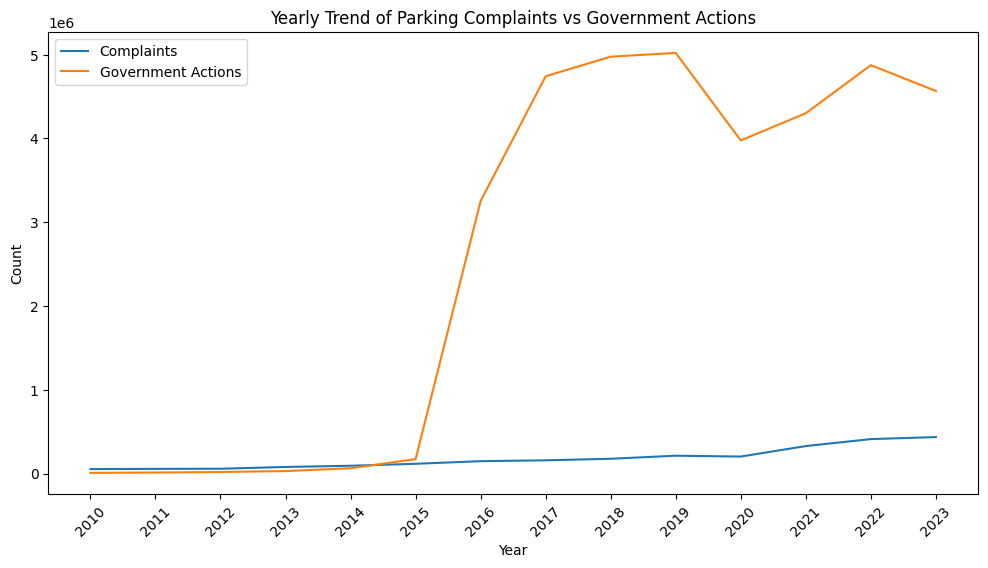

In [5]:
import matplotlib.pyplot as plt

# Extract year from 'month' for aggregation
merged_df['year'] = pd.to_datetime(merged_df['Month'].astype(str)).dt.year

# Aggregate data by year
yearly_data = merged_df.groupby('year').agg({'complaints_count': 'sum', 'action_count': 'sum'}).reset_index()

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(yearly_data['year'], yearly_data['complaints_count'], label='Complaints')
plt.plot(yearly_data['year'], yearly_data['action_count'], label='Government Actions')

plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Yearly Trend of Parking Complaints vs Government Actions')
plt.legend()
plt.xticks(yearly_data['year'], rotation=45)  # Ensure all years are displayed as x-ticks

plt.show()

